In [88]:
%matplotlib inline
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [89]:
class NeuralNet(object):
    def __init__(self, Lambda=0):
        
        # hyperparameters
        self.iLayerSize = 2
        self.hLayerSize = 3
        self.oLayerSize = 1
        self.Lambda = Lambda
        
        # randomize weights
        self.W1 = np.random.randn(self.iLayerSize, self.hLayerSize)
        self.W2 = np.random.randn(self.hLayerSize, self.oLayerSize)
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def d_sigmoid(self, z):
        return np.exp(-z) / ((1 + np.exp(-z))**2)
    
    def forward(self, X):
        '''push input data though net'''
        
        # second layer (hidden)
        self.z2 = np.dot(X, self.W1)
        
        # activation on second layer
        self.a2 = self.sigmoid(self.z2)
        
        # third layer (output)
        self.z3 = np.dot(self.a2, self.W2)
        
        # activation on third layer
        return self.sigmoid(self.z3)
    
        
    def cost(self, X, Y):
        self.predicted = self.forward(X)
        diff = Y - self.predicted
        
        J = 0.5 * np.sum(diff**2) / X.shape[0]
        regularizator = (self.Lambda/2)*(np.sum(self.W1**2) + np.sum(self.W2**2))
        return J + regularizator
    
    def d_cost(self, X, Y):
        self.predicted = self.forward(X)
        diff = Y - self.predicted
        
        delta3 = np.multiply(-diff, self.d_sigmoid(self.z3))
        dJW2 = np.dot(self.a2.T, delta3) / X.shape[0] + self.Lambda * self.W2
        
        delta2 = np.dot(delta3, self.W2.T) * self.d_sigmoid(self.z2)
        dJW1 = np.dot(X.T, delta2) / X.shape[0] + self.Lambda * self.W1
        
        return dJW1, dJW2
    
    # getter and setter
    def getWeights(self):
        return np.concatenate((self.W1.ravel(), self.W2.ravel()))
    
    def setWeights(self, W):
        
        W1_start = 0
        W1_end = W1_start + self.iLayerSize * self.hLayerSize
        
        W2_start = W1_end
        W2_end = W2_start + self.hLayerSize * self.oLayerSize
        
        self.W1 = np.reshape(W[W1_start:W1_end], (self.iLayerSize, self.hLayerSize))
        self.W2 = np.reshape(W[W2_start:W2_end], (self.hLayerSize, self.oLayerSize))
        
    def computeGrads(self, X, Y):
        dJW1, dJW2 = self.d_cost(X, Y)
        return np.concatenate((dJW1.ravel(), dJW2.ravel()))

In [90]:
def computeNumGrads(N, X, y, acc=1e-4):
    initialWeights = N.getWeights()
    
    numgrad = np.zeros(initialWeights.shape)
    perturb = np.zeros(initialWeights.shape)
    
    for p in range(len(initialWeights)):
        perturb[p] = acc
        
        N.setWeights(initialWeights + perturb)
        loss2 = N.cost(X, y)
        
        N.setWeights(initialWeights - perturb)
        loss1 = N.cost(X, y)
        
        numgrad[p] = (loss2 - loss1) / (2*acc)
        
        perturb[p] = 0
        
    N.setWeights(initialWeights)
    
    return numgrad

In [91]:
class Trainer(object):
    
    def __init__(self, N):
        # N -- instance of Neural net class
        self.N = N
        
    def callbackF(self, W):
        self.N.setWeights(W)
        self.J.append(self.N.cost(self.X, self.y))
        self.testJ.append(self.N.cost(self.testX, self.testY))
        
    def costWrapper(self, W, X, y):
        self.N.setWeights(W)
        cost = self.N.cost(X, y)
        grad = self.N.computeGrads(X,y)
        
        return cost, grad
    
    def train(self, trainX, trainY, testX, testY):
        #Make an internal variable for the callback function:
        self.X = trainX
        self.y = trainY
        
        self.testX = testX
        self.testY = testY

        # for storing costs
        self.J = []
        self.testJ = []
        
        W0 = self.N.getWeights()

        self.optimizationResults = optimize.minimize(self.costWrapper, W0, jac=True, method='BFGS',
                                                     args=(trainX, trainY),
                                                     options={'maxiter': 40, 'disp': True},
                                                     callback=self.callbackF)

        self.N.setWeights(self.optimizationResults.x)
        

In [92]:
X = np.array([[3, 5], [5, 1], [10, 2]])
Y = np.array([75, 82, 93])

In [93]:
NN = NeuralNet(Lambda=0.1)
NN.forward(X)

array([[ 0.4619738 ],
       [ 0.34578015],
       [ 0.33356031]])

In [94]:
#Training Data:
trainX = np.array(([3, 5], [5, 1], [10, 2], [6, 1.5]), dtype=float)
trainY = np.array(([75], [82], [93], [70]), dtype=float)

#Testing Data:
testX = np.array(([4, 5.5], [4.5,  1], [9, 2.5], [6, 2]), dtype=float)
testY = np.array(([70], [89], [85], [75]), dtype=float)

#Normalize:
trainX = trainX / np.amax(trainX, axis=0)
trainY = trainY / 100 #Max test score is 100

#Normalize by max of training data:
testX = testX / np.amax(trainX, axis=0)
testY = testY / 100 #Max test score is 100

In [95]:
#Train network with new data:
NN = NeuralNet()

#Make sure our gradients our correct after making changes:
numgrad = computeNumGrads(NN, trainX, trainY)
grad = NN.computeGrads(trainX, trainY)

#Should be less than 1e-8:
np.linalg.norm(grad-numgrad) / np.linalg.norm(grad+numgrad)

6.3234849630778776e-11

In [96]:
T = Trainer(NN)
T.train(trainX, trainY, testX, testY)

         Current function value: 0.002078
         Iterations: 40
         Function evaluations: 49
         Gradient evaluations: 49


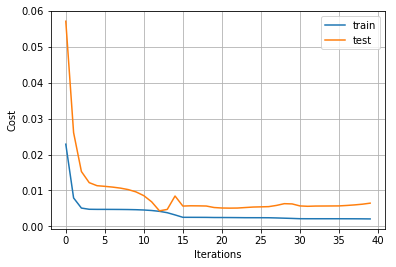

In [97]:
plt.plot(T.J, label='train')
plt.plot(T.testJ, label='test')
plt.grid(1)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.legend()